# Importing relavant libraries

In [1]:
import pandas       as pd
import tensorflow   as tf
import datetime     as dt

from sklearn.preprocessing import StandardScaler

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Importing our dataset

In [3]:
df =  (
pd.concat([                                                                                 # concatenating all the files
pd.read_csv(f'data\BTCUSDT-1m-{i}.csv',
    usecols   = ['openTime', 'open', 'high', 'low', 'volume', 'numberOfTrades', 'close'],   # features
    index_col = 'openTime',                                                                 # index of dataset
    # nrows     = 10_000,
    converters= {
        'openTime': lambda t: dt.datetime.fromtimestamp(int(t)/1000)                        # converting openTime from miliseconds to datetime object
    }
)
for i in range(5)
]))

df

,open,high,low,close,volume,numberOfTrades
openTime,,,,,,
2017-08-17 09:00:00,4261.48,4261.48,4261.48,4261.48,1.775183,3
2017-08-17 09:01:00,4261.48,4261.48,4261.48,4261.48,0.000000,0
2017-08-17 09:02:00,4280.56,4280.56,4280.56,4280.56,0.261074,2
2017-08-17 09:03:00,4261.48,4261.48,4261.48,4261.48,0.012008,3
2017-08-17 09:04:00,4261.48,4261.48,4261.48,4261.48,0.140796,1
...,...,...,...,...,...,...
2021-10-01 04:55:00,43780.76,43785.55,43725.40,43738.52,19.086670,572
2021-10-01 04:56:00,43738.53,43744.35,43723.39,43738.24,8.455620,331
2021-10-01 04:57:00,43734.80,43781.35,43734.80,43769.11,11.837510,343


# plotting closing prices vs openTime

<AxesSubplot:xlabel='openTime', ylabel='close price'>

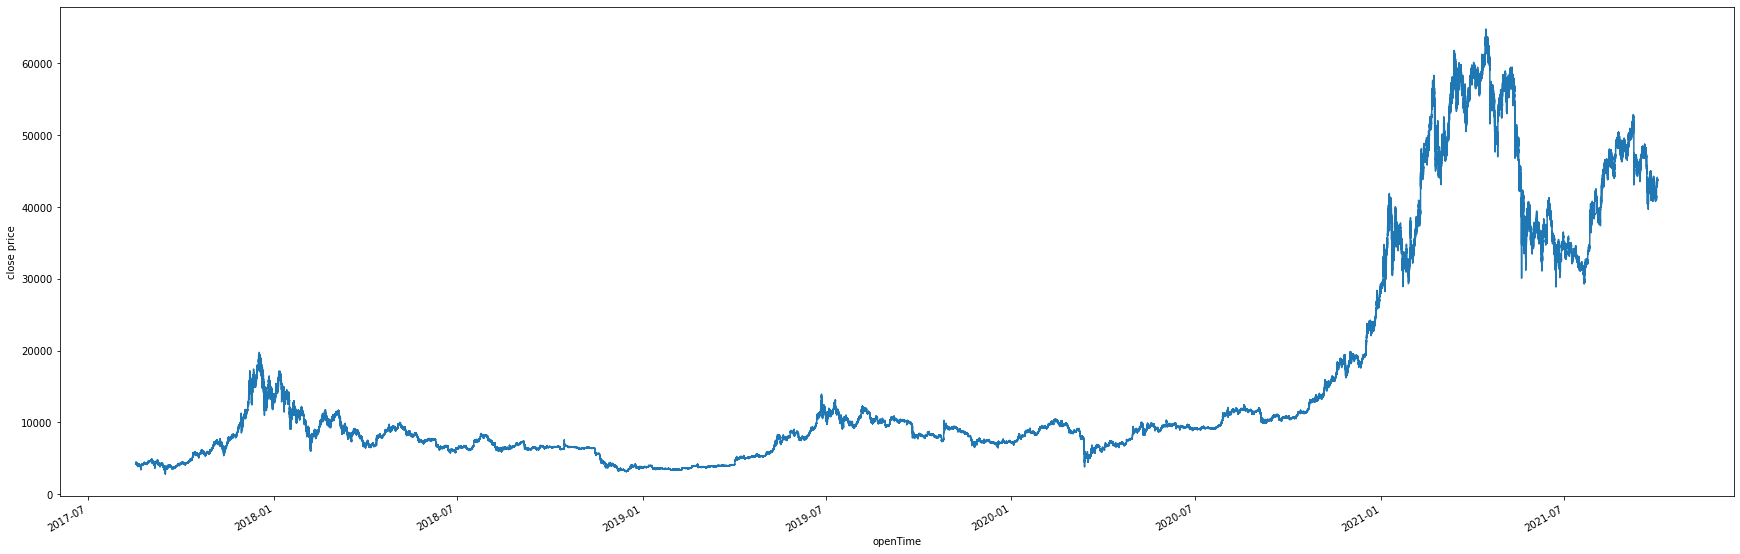

In [4]:
df['close'].plot(figsize= [30,10], ylabel= 'close price')

# Preprocessing

In [18]:
nPast       = 100       # number of past values
nFuture     = 1         # number of future predictions
batchSize   = 1000      # batch size
m,n         = df.shape  # number of rows and features

scaler      = StandardScaler()
df.iloc[:]  = scaler.fit(df).transform(df)  # scaling data to 0 mean and 1 variance

ds = (
tf.data.Dataset
    .from_tensor_slices(df)                                         # dataframe to a dataset object
    .window(size= nPast+nFuture, shift= 1, drop_remainder= True)    # windowing the dataset
    .flat_map(lambda w: w.batch(nPast+nFuture))                     # converting each window from dataset into a tensor object
    .map(lambda w: (w[:nPast, :], w[-1:, 3]))                       # splitting the window into features (data for last nPast minutes) and labels (closing price nFuture minutes ahead)
    .shuffle(10000)                                                 # shuffling
    # .batch(batchSize)                                               # batching
)

m = 100_000
ds = ds.take(m)

a = 10_000          # 10k samples for test and validation
a = int(0.1 * m)    # 10% samples for test and validation

dsTest       = ds.take(a)        .batch(batchSize)   # first 10k entries for test
dsValidation = ds.skip(a).take(a).batch(batchSize)   # second 10k entries for validation
dsTrain      = ds.skip(a+a)      .batch(batchSize)   # rest of the entries for training

# Model definition

In [19]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input  (shape= [nPast, n]),
    tf.keras.layers.GRU    (units= 128       ),
    tf.keras.layers.Dropout(rate = 0.1       ),
    tf.keras.layers.Dense  (units= 1         ),
])

model.compile(
    # loss        = tf.keras.losses.Huber()   ,
    # loss        = tf.keras.losses.MeanAbsoluteError(),
    loss        = tf.keras.losses.MeanSquaredError(),
    optimizer   = tf.keras.optimizers.Adam(),
    metrics     = [
        tf.keras.metrics.MAE ,  # mean absolute error
        tf.keras.metrics.MAPE,  # mean absolute percentage error
        tf.keras.metrics.MSE ,  # mean squared error
    ]
)

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, 128)               52224     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 52,353
Trainable params: 52,353
Non-trainable params: 0
_________________________________________________________________


# model training

In [20]:
history = model.fit(dsTrain,                                    # training data
    epochs         = 30,                                        # number of epochs
    validation_data= dsValidation,                              # validation data
    callbacks      = [
        tf.keras.callbacks.BackupAndRestore('model/backup'),    # restore saved model
        tf.keras.callbacks.ModelCheckpoint('model/checkpoint',  # save current best model
            monitor       = 'val_mean_absolute_error',
            save_best_only= True,
)])

Epoch 1/30
     80/Unknown - 21s 182ms/step - loss: 0.0320 - mean_absolute_error: 0.1081 - mean_absolute_percentage_error: 14.9935 - mean_squared_error: 0.0320

INFO:tensorflow:Assets written to: model\checkpoint\assets


INFO:tensorflow:Assets written to: model\checkpoint\assets


80/80 [==============================] - 34s 348ms/step - loss: 0.0320 - mean_absolute_error: 0.1081 - mean_absolute_percentage_error: 14.9935 - mean_squared_error: 0.0320 - val_loss: 0.0015 - val_mean_absolute_error: 0.0380 - val_mean_absolute_percentage_error: 5.2416 - val_mean_squared_error: 0.0015
Epoch 2/30
80/80 [==============================] - ETA: 0s - loss: 0.0032 - mean_absolute_error: 0.0447 - mean_absolute_percentage_error: 6.2853 - mean_squared_error: 0.0032

INFO:tensorflow:Assets written to: model\checkpoint\assets


INFO:tensorflow:Assets written to: model\checkpoint\assets


80/80 [==============================] - 30s 322ms/step - loss: 0.0032 - mean_absolute_error: 0.0447 - mean_absolute_percentage_error: 6.2853 - mean_squared_error: 0.0032 - val_loss: 0.0011 - val_mean_absolute_error: 0.0324 - val_mean_absolute_percentage_error: 4.4695 - val_mean_squared_error: 0.0011
Epoch 3/30
80/80 [==============================] - 24s 243ms/step - loss: 0.0025 - mean_absolute_error: 0.0400 - mean_absolute_percentage_error: 5.6198 - mean_squared_error: 0.0025 - val_loss: 0.0011 - val_mean_absolute_error: 0.0330 - val_mean_absolute_percentage_error: 4.5489 - val_mean_squared_error: 0.0011
Epoch 4/30
80/80 [==============================] - ETA: 0s - loss: 0.0020 - mean_absolute_error: 0.0355 - mean_absolute_percentage_error: 4.9930 - mean_squared_error: 0.0020

INFO:tensorflow:Assets written to: model\checkpoint\assets


INFO:tensorflow:Assets written to: model\checkpoint\assets


80/80 [==============================] - 30s 325ms/step - loss: 0.0020 - mean_absolute_error: 0.0355 - mean_absolute_percentage_error: 4.9930 - mean_squared_error: 0.0020 - val_loss: 8.9468e-04 - val_mean_absolute_error: 0.0294 - val_mean_absolute_percentage_error: 4.0519 - val_mean_squared_error: 8.9468e-04
Epoch 5/30
80/80 [==============================] - ETA: 0s - loss: 0.0016 - mean_absolute_error: 0.0315 - mean_absolute_percentage_error: 4.4332 - mean_squared_error: 0.0016

INFO:tensorflow:Assets written to: model\checkpoint\assets


INFO:tensorflow:Assets written to: model\checkpoint\assets


80/80 [==============================] - 30s 327ms/step - loss: 0.0016 - mean_absolute_error: 0.0315 - mean_absolute_percentage_error: 4.4332 - mean_squared_error: 0.0016 - val_loss: 7.1967e-04 - val_mean_absolute_error: 0.0264 - val_mean_absolute_percentage_error: 3.6358 - val_mean_squared_error: 7.1967e-04
Epoch 6/30
80/80 [==============================] - ETA: 0s - loss: 0.0013 - mean_absolute_error: 0.0280 - mean_absolute_percentage_error: 3.9348 - mean_squared_error: 0.0013

INFO:tensorflow:Assets written to: model\checkpoint\assets


INFO:tensorflow:Assets written to: model\checkpoint\assets


80/80 [==============================] - 30s 324ms/step - loss: 0.0013 - mean_absolute_error: 0.0280 - mean_absolute_percentage_error: 3.9348 - mean_squared_error: 0.0013 - val_loss: 5.2816e-04 - val_mean_absolute_error: 0.0226 - val_mean_absolute_percentage_error: 3.1116 - val_mean_squared_error: 5.2816e-04
Epoch 7/30
80/80 [==============================] - ETA: 0s - loss: 9.8386e-04 - mean_absolute_error: 0.0249 - mean_absolute_percentage_error: 3.4963 - mean_squared_error: 9.8386e-04

INFO:tensorflow:Assets written to: model\checkpoint\assets


INFO:tensorflow:Assets written to: model\checkpoint\assets


80/80 [==============================] - 30s 333ms/step - loss: 9.8386e-04 - mean_absolute_error: 0.0249 - mean_absolute_percentage_error: 3.4963 - mean_squared_error: 9.8386e-04 - val_loss: 3.8634e-04 - val_mean_absolute_error: 0.0193 - val_mean_absolute_percentage_error: 2.6622 - val_mean_squared_error: 3.8634e-04
Epoch 8/30
80/80 [==============================] - ETA: 0s - loss: 8.1624e-04 - mean_absolute_error: 0.0227 - mean_absolute_percentage_error: 3.1899 - mean_squared_error: 8.1624e-04

INFO:tensorflow:Assets written to: model\checkpoint\assets


INFO:tensorflow:Assets written to: model\checkpoint\assets


80/80 [==============================] - 30s 326ms/step - loss: 8.1624e-04 - mean_absolute_error: 0.0227 - mean_absolute_percentage_error: 3.1899 - mean_squared_error: 8.1624e-04 - val_loss: 3.8157e-04 - val_mean_absolute_error: 0.0193 - val_mean_absolute_percentage_error: 2.6597 - val_mean_squared_error: 3.8157e-04
Epoch 9/30
80/80 [==============================] - ETA: 0s - loss: 7.1702e-04 - mean_absolute_error: 0.0213 - mean_absolute_percentage_error: 2.9915 - mean_squared_error: 7.1702e-04

INFO:tensorflow:Assets written to: model\checkpoint\assets


INFO:tensorflow:Assets written to: model\checkpoint\assets


80/80 [==============================] - 31s 340ms/step - loss: 7.1702e-04 - mean_absolute_error: 0.0213 - mean_absolute_percentage_error: 2.9915 - mean_squared_error: 7.1702e-04 - val_loss: 3.2081e-04 - val_mean_absolute_error: 0.0177 - val_mean_absolute_percentage_error: 2.4458 - val_mean_squared_error: 3.2081e-04
Epoch 10/30
80/80 [==============================] - ETA: 0s - loss: 6.4711e-04 - mean_absolute_error: 0.0202 - mean_absolute_percentage_error: 2.8352 - mean_squared_error: 6.4711e-04

INFO:tensorflow:Assets written to: model\checkpoint\assets


INFO:tensorflow:Assets written to: model\checkpoint\assets


80/80 [==============================] - 31s 331ms/step - loss: 6.4711e-04 - mean_absolute_error: 0.0202 - mean_absolute_percentage_error: 2.8352 - mean_squared_error: 6.4711e-04 - val_loss: 1.0884e-04 - val_mean_absolute_error: 0.0102 - val_mean_absolute_percentage_error: 1.4089 - val_mean_squared_error: 1.0884e-04
Epoch 11/30
80/80 [==============================] - ETA: 0s - loss: 5.7523e-04 - mean_absolute_error: 0.0191 - mean_absolute_percentage_error: 2.6797 - mean_squared_error: 5.7523e-04

INFO:tensorflow:Assets written to: model\checkpoint\assets


INFO:tensorflow:Assets written to: model\checkpoint\assets


80/80 [==============================] - 30s 332ms/step - loss: 5.7523e-04 - mean_absolute_error: 0.0191 - mean_absolute_percentage_error: 2.6797 - mean_squared_error: 5.7523e-04 - val_loss: 9.8097e-05 - val_mean_absolute_error: 0.0097 - val_mean_absolute_percentage_error: 1.3446 - val_mean_squared_error: 9.8097e-05
Epoch 12/30
80/80 [==============================] - ETA: 0s - loss: 5.3131e-04 - mean_absolute_error: 0.0183 - mean_absolute_percentage_error: 2.5795 - mean_squared_error: 5.3131e-04

INFO:tensorflow:Assets written to: model\checkpoint\assets


INFO:tensorflow:Assets written to: model\checkpoint\assets


80/80 [==============================] - 29s 314ms/step - loss: 5.3131e-04 - mean_absolute_error: 0.0183 - mean_absolute_percentage_error: 2.5795 - mean_squared_error: 5.3131e-04 - val_loss: 2.6593e-05 - val_mean_absolute_error: 0.0049 - val_mean_absolute_percentage_error: 0.6805 - val_mean_squared_error: 2.6593e-05
Epoch 13/30
80/80 [==============================] - ETA: 0s - loss: 5.0649e-04 - mean_absolute_error: 0.0179 - mean_absolute_percentage_error: 2.5202 - mean_squared_error: 5.0649e-04

INFO:tensorflow:Assets written to: model\checkpoint\assets


INFO:tensorflow:Assets written to: model\checkpoint\assets


80/80 [==============================] - 31s 339ms/step - loss: 5.0649e-04 - mean_absolute_error: 0.0179 - mean_absolute_percentage_error: 2.5202 - mean_squared_error: 5.0649e-04 - val_loss: 2.2331e-05 - val_mean_absolute_error: 0.0045 - val_mean_absolute_percentage_error: 0.6259 - val_mean_squared_error: 2.2331e-05
Epoch 14/30
80/80 [==============================] - 23s 228ms/step - loss: 4.8194e-04 - mean_absolute_error: 0.0174 - mean_absolute_percentage_error: 2.4551 - mean_squared_error: 4.8194e-04 - val_loss: 3.1303e-05 - val_mean_absolute_error: 0.0055 - val_mean_absolute_percentage_error: 0.7534 - val_mean_squared_error: 3.1303e-05
Epoch 15/30
80/80 [==============================] - ETA: 0s - loss: 4.6588e-04 - mean_absolute_error: 0.0172 - mean_absolute_percentage_error: 2.4166 - mean_squared_error: 4.6588e-04

INFO:tensorflow:Assets written to: model\checkpoint\assets


INFO:tensorflow:Assets written to: model\checkpoint\assets


80/80 [==============================] - 30s 324ms/step - loss: 4.6588e-04 - mean_absolute_error: 0.0172 - mean_absolute_percentage_error: 2.4166 - mean_squared_error: 4.6588e-04 - val_loss: 1.9777e-05 - val_mean_absolute_error: 0.0043 - val_mean_absolute_percentage_error: 0.5932 - val_mean_squared_error: 1.9777e-05
Epoch 16/30
80/80 [==============================] - ETA: 0s - loss: 4.5913e-04 - mean_absolute_error: 0.0170 - mean_absolute_percentage_error: 2.3909 - mean_squared_error: 4.5913e-04

INFO:tensorflow:Assets written to: model\checkpoint\assets


INFO:tensorflow:Assets written to: model\checkpoint\assets


80/80 [==============================] - 30s 327ms/step - loss: 4.5913e-04 - mean_absolute_error: 0.0170 - mean_absolute_percentage_error: 2.3909 - mean_squared_error: 4.5913e-04 - val_loss: 1.1948e-05 - val_mean_absolute_error: 0.0033 - val_mean_absolute_percentage_error: 0.4529 - val_mean_squared_error: 1.1948e-05
Epoch 17/30
80/80 [==============================] - 23s 232ms/step - loss: 4.4702e-04 - mean_absolute_error: 0.0168 - mean_absolute_percentage_error: 2.3642 - mean_squared_error: 4.4702e-04 - val_loss: 1.5635e-05 - val_mean_absolute_error: 0.0038 - val_mean_absolute_percentage_error: 0.5251 - val_mean_squared_error: 1.5635e-05
Epoch 18/30
80/80 [==============================] - ETA: 0s - loss: 4.4143e-04 - mean_absolute_error: 0.0167 - mean_absolute_percentage_error: 2.3510 - mean_squared_error: 4.4143e-04

INFO:tensorflow:Assets written to: model\checkpoint\assets


INFO:tensorflow:Assets written to: model\checkpoint\assets


80/80 [==============================] - 30s 327ms/step - loss: 4.4143e-04 - mean_absolute_error: 0.0167 - mean_absolute_percentage_error: 2.3510 - mean_squared_error: 4.4143e-04 - val_loss: 1.0840e-05 - val_mean_absolute_error: 0.0031 - val_mean_absolute_percentage_error: 0.4297 - val_mean_squared_error: 1.0840e-05
Epoch 19/30
80/80 [==============================] - 22s 228ms/step - loss: 4.3707e-04 - mean_absolute_error: 0.0167 - mean_absolute_percentage_error: 2.3427 - mean_squared_error: 4.3707e-04 - val_loss: 1.1679e-05 - val_mean_absolute_error: 0.0032 - val_mean_absolute_percentage_error: 0.4489 - val_mean_squared_error: 1.1679e-05
Epoch 20/30
80/80 [==============================] - ETA: 0s - loss: 4.2223e-04 - mean_absolute_error: 0.0163 - mean_absolute_percentage_error: 2.2978 - mean_squared_error: 4.2223e-04

INFO:tensorflow:Assets written to: model\checkpoint\assets


INFO:tensorflow:Assets written to: model\checkpoint\assets


80/80 [==============================] - 29s 319ms/step - loss: 4.2223e-04 - mean_absolute_error: 0.0163 - mean_absolute_percentage_error: 2.2978 - mean_squared_error: 4.2223e-04 - val_loss: 6.7743e-06 - val_mean_absolute_error: 0.0024 - val_mean_absolute_percentage_error: 0.3319 - val_mean_squared_error: 6.7743e-06
Epoch 21/30
80/80 [==============================] - 22s 230ms/step - loss: 4.2275e-04 - mean_absolute_error: 0.0163 - mean_absolute_percentage_error: 2.2959 - mean_squared_error: 4.2275e-04 - val_loss: 1.8668e-05 - val_mean_absolute_error: 0.0042 - val_mean_absolute_percentage_error: 0.5780 - val_mean_squared_error: 1.8668e-05
Epoch 22/30
80/80 [==============================] - 22s 221ms/step - loss: 4.1902e-04 - mean_absolute_error: 0.0163 - mean_absolute_percentage_error: 2.2953 - mean_squared_error: 4.1902e-04 - val_loss: 1.4088e-05 - val_mean_absolute_error: 0.0036 - val_mean_absolute_percentage_error: 0.4977 - val_mean_squared_error: 1.4088e-05
Epoch 23/30
80/80 [===

INFO:tensorflow:Assets written to: model\checkpoint\assets


INFO:tensorflow:Assets written to: model\checkpoint\assets


80/80 [==============================] - 30s 323ms/step - loss: 4.1094e-04 - mean_absolute_error: 0.0161 - mean_absolute_percentage_error: 2.2684 - mean_squared_error: 4.1094e-04 - val_loss: 1.5915e-06 - val_mean_absolute_error: 9.3673e-04 - val_mean_absolute_percentage_error: 0.1293 - val_mean_squared_error: 1.5915e-06
Epoch 25/30
80/80 [==============================] - 22s 231ms/step - loss: 4.0440e-04 - mean_absolute_error: 0.0160 - mean_absolute_percentage_error: 2.2499 - mean_squared_error: 4.0440e-04 - val_loss: 1.9268e-06 - val_mean_absolute_error: 0.0011 - val_mean_absolute_percentage_error: 0.1528 - val_mean_squared_error: 1.9268e-06
Epoch 26/30
80/80 [==============================] - 23s 233ms/step - loss: 4.0456e-04 - mean_absolute_error: 0.0160 - mean_absolute_percentage_error: 2.2521 - mean_squared_error: 4.0456e-04 - val_loss: 3.5847e-06 - val_mean_absolute_error: 0.0017 - val_mean_absolute_percentage_error: 0.2293 - val_mean_squared_error: 3.5847e-06
Epoch 27/30
80/80 

# plotting metrics vs epochs

<AxesSubplot:title={'center':'relatively rescaled metrics'}>

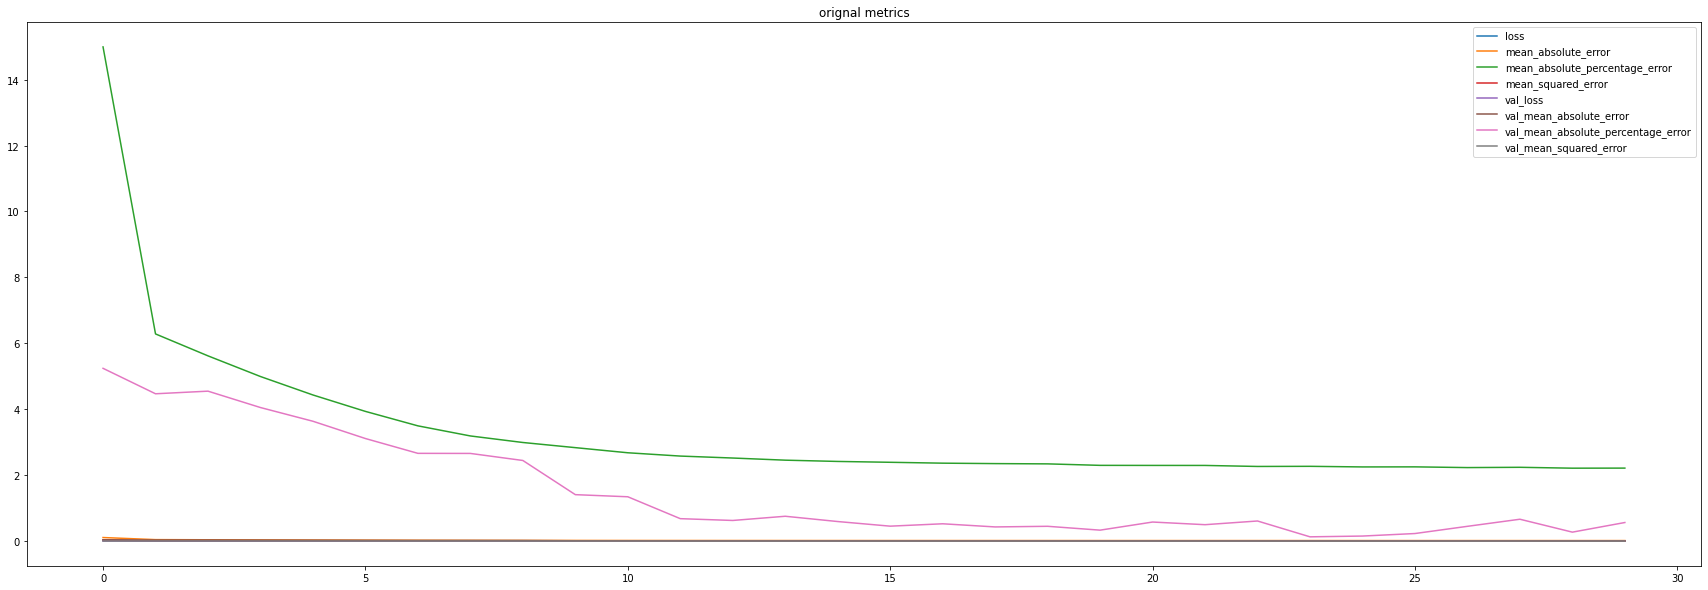

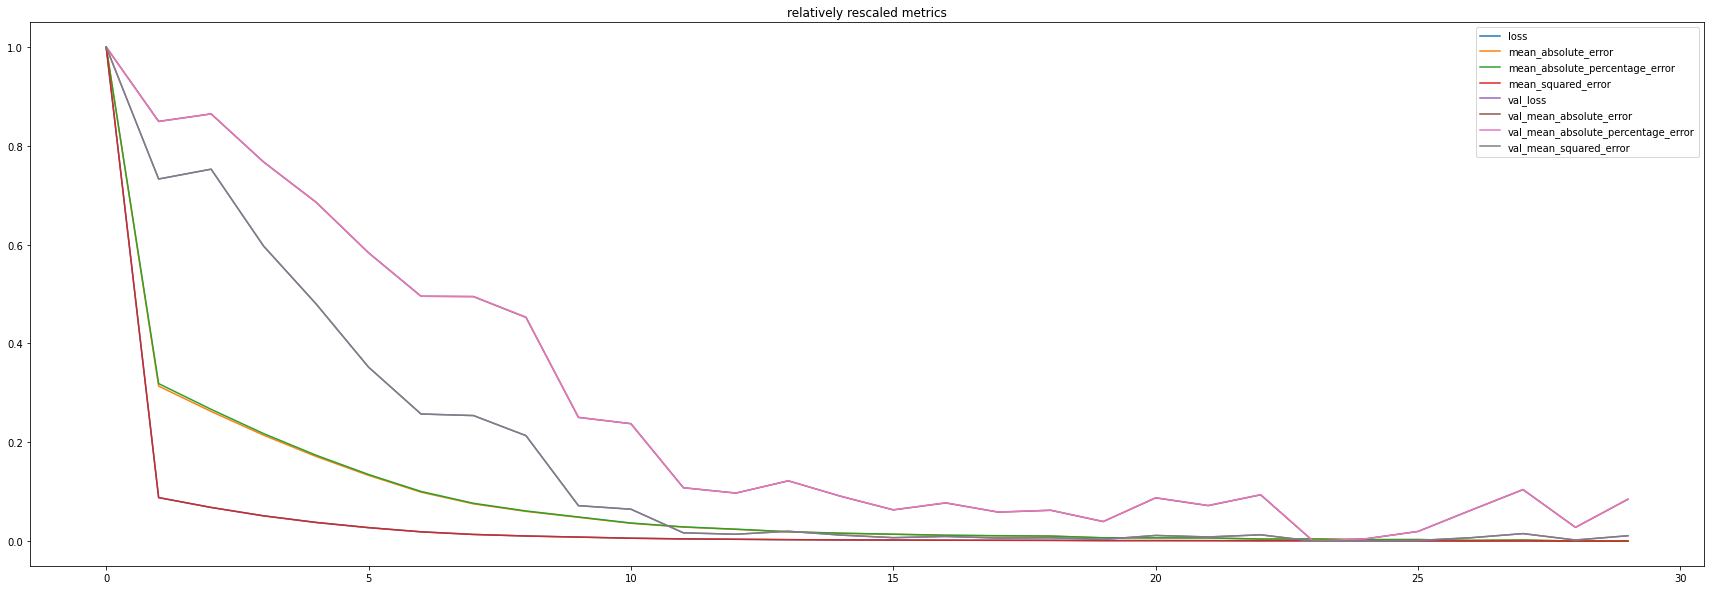

In [21]:
temp = pd.DataFrame(history.history)
temp.plot(figsize= [30,10], title= 'orignal metrics')

temp -= temp.min()
temp /= temp.max()

temp.plot(figsize= [30,10], title= 'relatively rescaled metrics')

In [9]:
model.evaluate(dsTest)

1/1 [==============================] - 2s 2s/step - loss: 0.0063 - mean_absolute_error: 0.0063 - mean_absolute_percentage_error: 0.8393 - mean_squared_error: 4.8820e-05


[0.006255187559872866,
 0.006255187559872866,
 0.8393213152885437,
 4.8819638323038816e-05]

In [10]:
temp = (
tf.data.Dataset
    .from_tensor_slices(df)
    .window(size= nPast+nFuture, shift= 1, drop_remainder= True)
    .flat_map(lambda w: w.batch(nPast+nFuture))
    .map(lambda w: w[:nPast, :])
    .batch(m)
)

y = df['close'][nPast + nFuture - 1:]
p = model.predict(temp).ravel()

In [ ]:
y.shape, p.shape

<AxesSubplot:xlabel='openTime'>

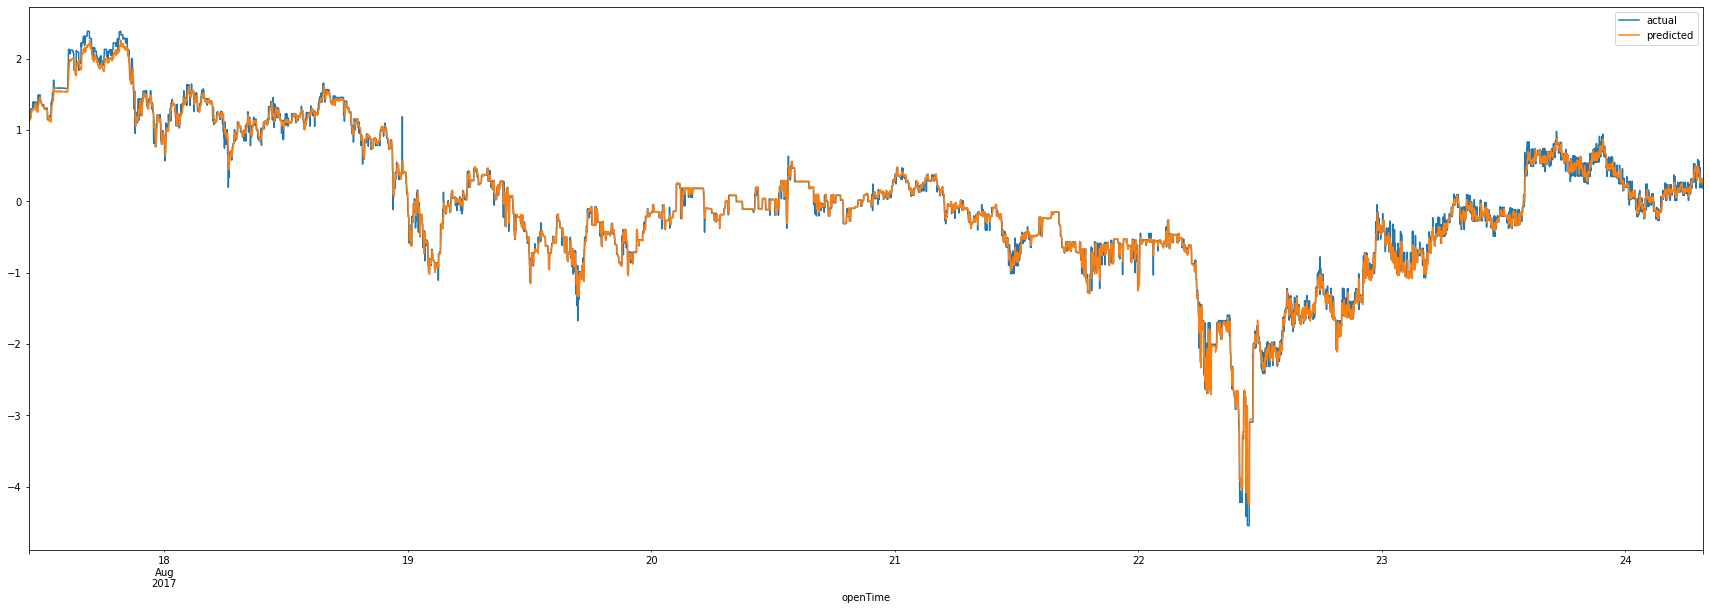

In [ ]:
i = 0
j = i + 10_000

pd.DataFrame({
    'actual'    : y.iloc[i:j],
    'predicted' : p     [i:j],

}).plot(figsize= [30, 10])